In [48]:
# import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 8)

In [75]:
# data parameters
n_monto_carlo = 10 ** 5
n_assets = 7
risky_asset = ['TSLA', 'AAPL', 'GOOGL', 'MSFT', 'NVDA', 'AMZN', 'META']

In [80]:
# download the data
prices_df = pd.read_csv("LSTM.csv")
prices_df = prices_df[1201:]
for i in risky_asset:
    prices_df.drop(columns=[f'Observed_{i}'], inplace=True)
    prices_df.drop(columns=[f'Train_Prediction_{i}'], inplace=True)
prices_df.set_index('Date', inplace=True)
print(f'read {prices_df.shape[0]} rows of data.')
N_DAYS = prices_df.shape[0]
prices_df = prices_df.dropna()
prices_df.head()

read 912 rows of data.


,Test_Prediction_AAPL,Test_Prediction_TSLA,Test_Prediction_MSFT,Test_Prediction_NVDA,Test_Prediction_GOOGL,Test_Prediction_AMZN,Test_Prediction_META
Date,,,,,,,
2020-10-09,113.774506,144.215775,210.893967,140.880646,74.161888,161.659164,264.265137
2020-10-12,115.756104,146.984451,216.236557,140.095306,75.491676,166.488983,264.946411
2020-10-13,123.116142,149.829834,221.947418,144.883682,78.158653,174.337845,276.111237
2020-10-14,119.847557,151.321594,223.439072,145.113754,78.280891,174.373001,276.496796
2020-10-15,119.936707,156.348328,221.395721,143.531876,78.101959,170.360092,272.226685


In [87]:
# show the percentage returns

returns_df = prices_df.pct_change()
returns_df.dropna(inplace=True)
returns_df.head()

,Test_Prediction_AAPL,Test_Prediction_TSLA,Test_Prediction_MSFT,Test_Prediction_NVDA,Test_Prediction_GOOGL,Test_Prediction_AMZN,Test_Prediction_META
Date,,,,,,,
2020-10-12,0.017417,0.019198,0.025333,-0.005575,0.017931,0.029877,0.002578
2020-10-13,0.063582,0.019358,0.026410,0.034179,0.035328,0.047143,0.042140
2020-10-14,-0.026549,0.009956,0.006721,0.001588,0.001564,0.000202,0.001396
2020-10-15,0.000744,0.033219,-0.009145,-0.010901,-0.002286,-0.023013,-0.015444
2020-10-16,-0.003964,-0.027259,-0.005538,-0.009020,-0.005029,-0.007389,-0.018509


In [88]:
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS
avg_returns, cov_mat

(Test_Prediction_AAPL     0.646003
 Test_Prediction_TSLA     0.880991
 Test_Prediction_MSFT     0.861501
 Test_Prediction_NVDA     2.482321
 Test_Prediction_GOOGL    1.046369
 Test_Prediction_AMZN     0.367265
 Test_Prediction_META     0.945587
 dtype: float64,
                        Test_Prediction_AAPL  Test_Prediction_TSLA  \
 Test_Prediction_AAPL               0.277949              0.295720   
 Test_Prediction_TSLA               0.295720              1.284018   
 Test_Prediction_MSFT               0.190342              0.237803   
 Test_Prediction_NVDA               0.308224              0.538240   
 Test_Prediction_GOOGL              0.194493              0.240927   
 Test_Prediction_AMZN               0.213258              0.322776   
 Test_Prediction_META               0.233807              0.305455   
 
                        Test_Prediction_MSFT  Test_Prediction_NVDA  \
 Test_Prediction_AAPL               0.190342              0.308224   
 Test_Prediction_TSLA               

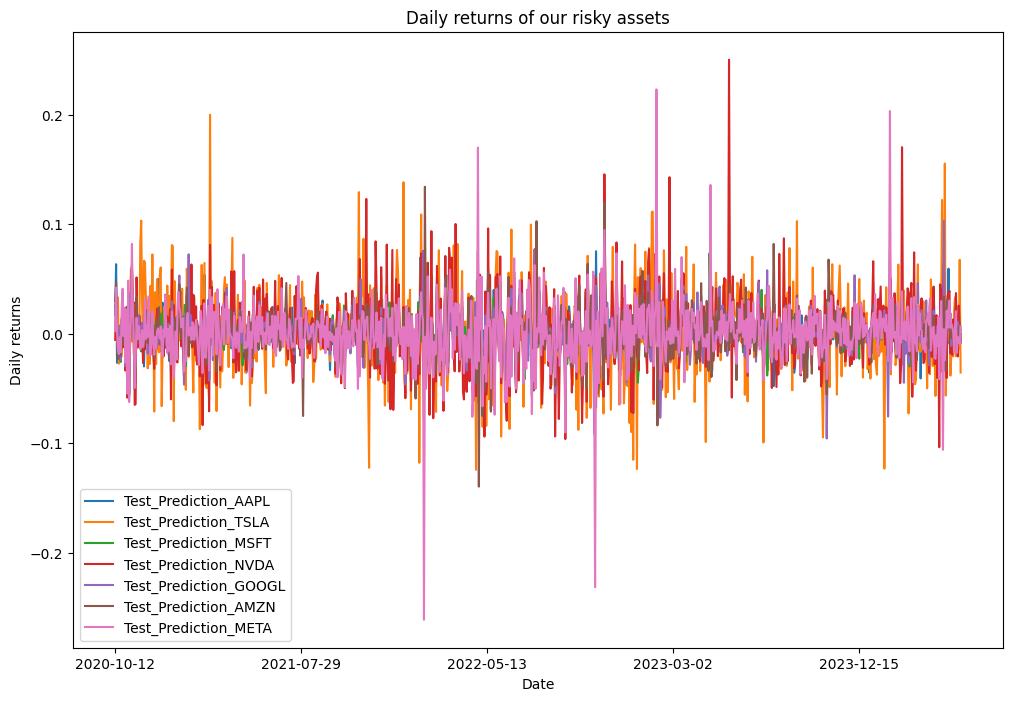

In [89]:
returns_df.plot(title='Daily returns of our risky assets')
plt.ylabel('Daily returns')
plt.show()

In [90]:
np.random.seed(666)
weights = np.random.random(size=(n_monto_carlo, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [91]:
portf_rtns = weights @ avg_returns

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(weights[i] @ cov_mat @ weights[i].T))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

In [92]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, 'sharpe_ratio': portf_sharpe_ratio})

In [93]:
n_internal = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), portf_results_df.returns.max(), n_internal)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for index in range(n_internal):
    if portf_rtns_ef[index] not in portf_rtns:
        indices_to_skip.append(index)
        continue
    matched_index = np.where(portf_rtns == portf_rtns_ef[index])
    portf_vol_ef.append(np.min(portf_vol[matched_index]))


# delete the inner dot
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

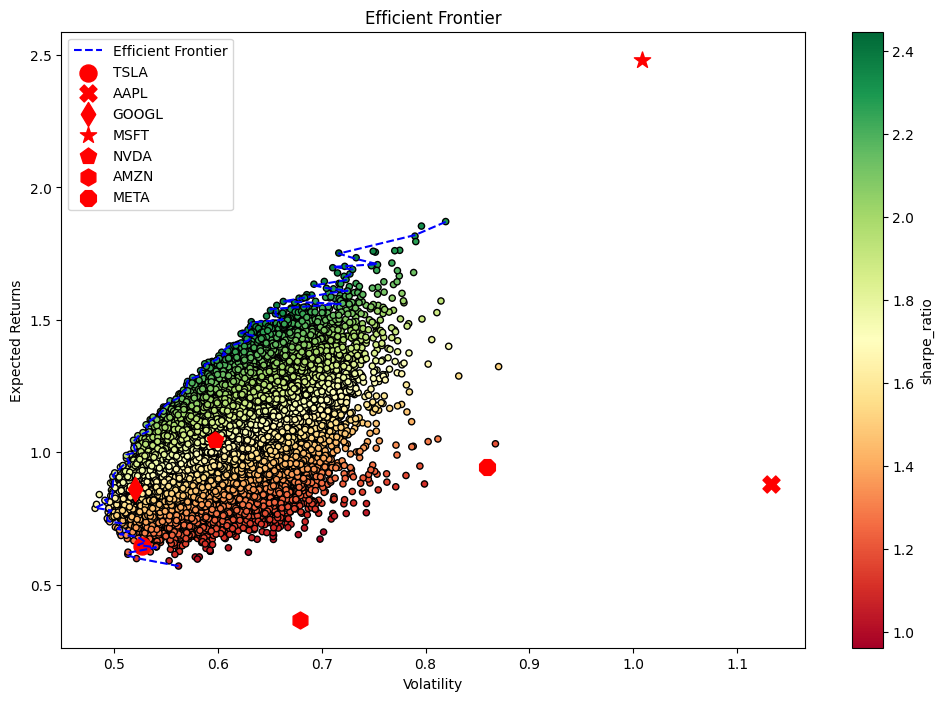

In [94]:
MARKS = ['o', 'X', 'd', '*', 'p', 'h', '8']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_asset[asset_index])
ax.legend()
plt.show()

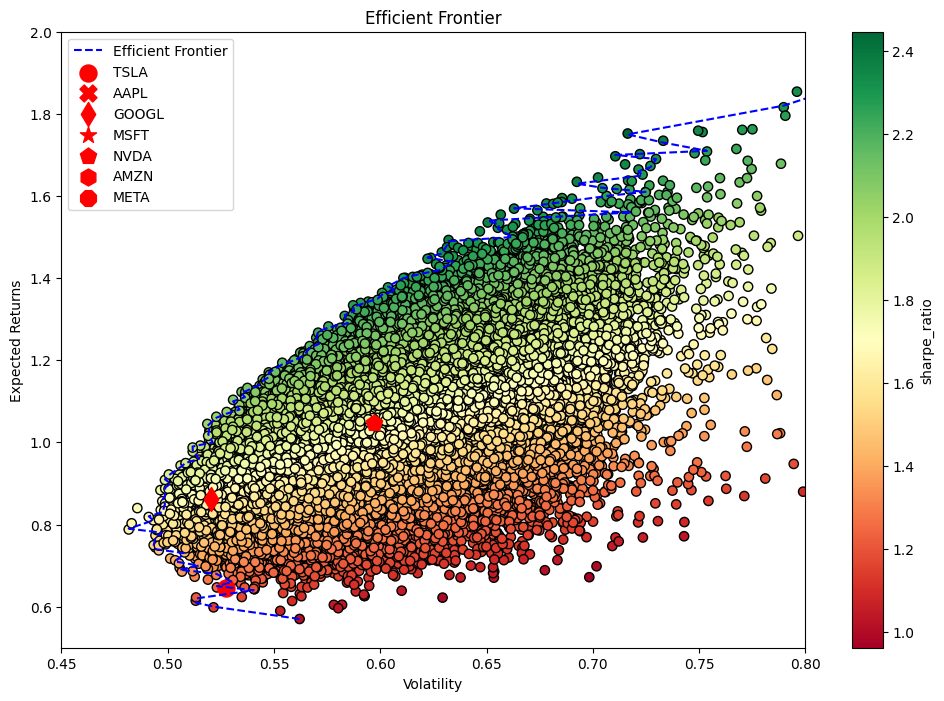

In [97]:
# a bigger figure
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax, s = 45)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier',\
       xlim = (0.45, 0.8), ylim = (0.5, 2))
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_asset[asset_index])
ax.legend()
plt.show()

In [98]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [99]:
print('Maximum Sharpe Ratio portfolio --->')
print('Performance:')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_asset, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio --->
Performance:
returns: 175.21% volatility: 71.64% sharpe_ratio: 244.58% 
Weights:
TSLA: 1.98% AAPL: 1.55% GOOGL: 18.71% MSFT: 52.41% NVDA: 25.02% AMZN: 0.25% META: 0.08% 

In [100]:
print('Minimum Volatility portfolio --->')
print('Performance:')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_asset, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio --->
Performance:
returns: 78.80% volatility: 48.17% sharpe_ratio: 163.60% 
Weights:
TSLA: 43.60% AAPL: 0.57% GOOGL: 36.81% MSFT: 0.46% NVDA: 13.73% AMZN: 2.85% META: 1.97% 

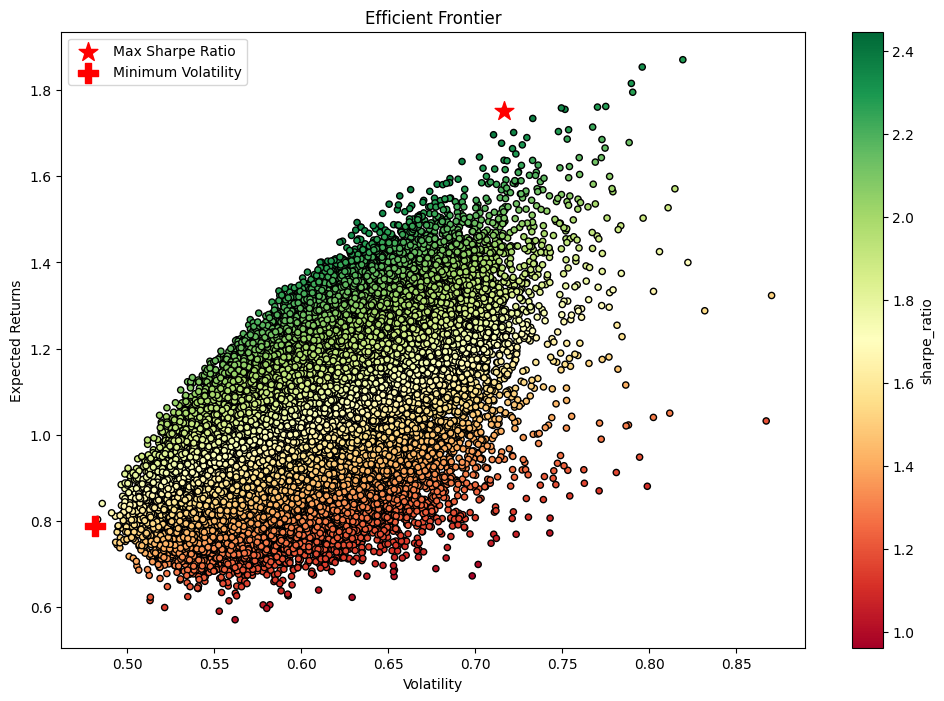

In [101]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, y=max_sharpe_portf.returns, 
           c='red', marker='*', s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, y=min_vol_portf.returns, 
           c='red', marker='P', s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.legend()
plt.show()